# Diffusion

In Eulerian ocean models, sub-grid scale dispersion of tracers such as heat, salt, or nutrients is often parameterized as a diffusive process. In Lagrangian particle simulations, sub-grid scale effects can be parameterized as a stochastic process, randomly displacing a particle position in proportion to the local eddy diffusivity ([Van Sebille et al. 2018](https://doi.org/10.1016/j.ocemod.2017.11.008)). Parameterizing sub-grid scale dispersion may be especially important when coarse velocity fields are used that do not resolve mesoscale eddies ([Shah et al., 2017](https://doi.org/10.1175/JPO-D-16-0098.1)). This tutorial explains how to use a sub-grid scale parameterization in _Parcels_ that is consistent with the advection-diffusion equation used in Eulerian models.

## Stochastic differential equations (SDE) consistent with advection-diffusion

The time-evolution of a stochastic process is described by a stochastic differential equation. The time-evolution of the conditional probability density of a stochastic process is described by a Fokker-Planck equation (FPE). The advection-diffusion equation, describing the evolution of a tracer, can be written as a Fokker-Planck equation. Therefore, we can formulate a stochastic differential equation for a particle in the Lagrangian frame undergoing advection with stochastic noise proportional to the local diffusivity in a way that is consistent with advection-diffusion in the Eulerian frame. For details, see [Shah et al., 2011](https://doi.org/10.1016/j.ocemod.2011.05.008) and [van Sebille et al., 2018](https://doi.org/10.1016/j.ocemod.2017.11.008).

The stochastic differential equation for a particle trajectory including diffusion is

$$
\begin{aligned}
    d\mathbf{X}(t) &\overset{\text{Îto}}{=} (\mathbf{u} + \nabla \cdot \mathbf{K}) dt + \mathbf{V}(t, \mathbf{X})\cdot d\mathbf{W}(t), \\
    \mathbf{X}(t_0) &= \mathbf{x}_0,
\end{aligned}
$$

where $\mathbf{X}$ is the particle position vector ($\mathbf{x}_0$ being the initial position vector), and $\mathbf{u}$ the velocity vector. $\mathbf{V}$ is calculated from the diffusivity tensor $\mathbf{K} = \frac{1}{2} \mathbf{V} \cdot \mathbf{V}^T$ and $d\mathbf{W}(t)$ a Wiener increment (normally distributed with zero mean and variance $dt$). Particle distributions obtained by solving the above equation are therefore consistent with Eulerian concentrations found by solving the advection-diffusion equation.

In three-dimensional ocean models diffusion operates along slopes of neutral buoyancy. To account for these slopes, the 3D diffusivity tensor $\mathbf{K}$ (and therefore $\mathbf{V}$) contains off-diagonal components. Three-dimensional advection-diffusion is not yet implemented in _Parcels_, but it is currently under development. Here we instead focus on the simpler case of diffusion in a horizontal plane, where diffusivity is specified only in the zonal and meridional direction, i.e.

$$
\mathbf{K}(x,y)=\begin{bmatrix}
K_x(x,y) & 0\\
0 & K_y(x,y)
\end{bmatrix}.
$$

The above stochastic differential equation then becomes

$$
\begin{align}
    dX(t) &= a_x dt + b_x dW_x(t), \quad &X(t_0) = x_0,\\
    dY(t) &= a_y dt + b_y dW_y(t), \quad &Y(t_0) = y_0,
\end{align}
$$

where $a_i = v_i + \partial_i K_i(x, y)$ is the deterministic drift term and $b_i = \sqrt{2K_i(x, y)}$ a stochastic noise term ($\partial_i$ denotes the partial derivative with respect to $i$).

## Numerical Approximations of SDEs

The simplest numerical approximation of the above SDEs is obtained by replacing $dt$ by a finite time discrete step $\Delta t$ and $dW$ by a discrete increment $\Delta W$, yielding the **Euler-Maruyama (EM) scheme** ([Maruyama, 1955](https://link.springer.com/article/10.1007/BF02846028)):

$$
\begin{equation}
    X_{n+1} = X_n + a_x \Delta t + b_x \Delta W_{n, x},
\end{equation}
$$

with a similar expression for $Y$.

A higher-order scheme is found by including extra terms from a Taylor expansion on our SDE, yielding the **Milstein scheme of order 1 (M1)**:

$$
\begin{equation}
    X_{n+1} = X_n + a_x \Delta t + b_x \Delta W_x + \frac{1}{2}b_x \partial_x b_x(\Delta W_{n, x}^2 - \Delta t),
\end{equation}
$$

which can be rewritten by explicitly writing $b_x\partial_x b_x$ as $\partial_x K_x(z)$:

$$
\begin{equation}
    X_{n+1} = X_n + v_x \Delta t + \frac{1}{2}\partial_x K_x(\Delta W_{n, x}^2 + \Delta t) + b\Delta W_n.
\end{equation}
$$

The extra term in the M1 scheme provides extra accuracy at negligible computational cost.

The spatial derivatives in the EM and M1 schemes can be approximated by a central difference. Higher order numerical schemes (see [Gräwe et al., 2012](https://doi.org/10.1007/s10236-012-0523-y)) include higher order derivatives.

An overview of numerical approximations for SDEs in a particle tracking setting can be found in [Gräwe (2011)](https://doi.org/10.1016/j.ocemod.2010.10.002).

## Using Advection-Diffusion Kernels in Parcels

The EM and M1 advection-diffusion approximations are available as `AdvectionDiffusionEM` and `AdvectionDiffusionM1`, respectively. The `AdvectionDiffusionM1` kernel should be the default choice, as the increased accuracy comes at negligible computational cost.

The advection component of these kernels is similar to that of the Explicit Euler advection kernel (`AdvectionEE`). In the special case where diffusivity is constant over the entire domain, the diffusion-only kernel `DiffusionUniformKh` can be used in combination with an advection kernel of choice. Since the diffusivity here is space-independent, gradients are not calculated, increasing efficiency. The diffusion-step can in this case be computed after or before advection, thus allowing you to chain kernels using the `+` operator.

Just like velocities, diffusivities are passed to Parcels in the form of `Field` objects. When using `DiffusionUniformKh`, they should be added to the `FieldSet` object as constant fields, e.g. `fieldset.add_constant_field("Kh_zonal", 1, mesh="flat")`.

To make a central difference approximation for computing the gradient in diffusivity, a resolution for this approximation `dres` is needed: _Parcels_ approximates the gradients in diffusivities by using their values at the particle's location ± `dres` (in both $x$ and $y$). A value of `dres` must be specified and added to the FieldSet by the user (e.g. `fieldset.add_constant("dres", 0.01)`). Currently, it is unclear what the best value of `dres` is. From experience, the size of `dres` should be smaller than the spatial resolution of the data, but within reasonable limits of machine precision to avoid numerical errors. We are working on a method to compute gradients differently so that specifying `dres` is not necessary anymore.

## Example: Impermeable Diffusivity Profile

Let's see the `AdvectionDiffusionM1` in action and see why it's preferable over the `AdvectionDiffusionEM` kernel. To do so, we create an idealized profile with diffusivities $K_\text{zonal}$ uniform everywhere ($K_\text{zonal} = \bar{K}=0.5$) and $K_\text{meridional}$ constant in the zonal direction, while having the following profile in the meridional direction:

$$
K_\text{meridional}(y) = \bar{K}\frac{2(1+\alpha)(1+2\alpha)}{\alpha^2H^{1+1/\alpha}} \begin{cases}
y(L-2y)^{1/\alpha},\quad 0 \leq y \leq L/2,\\
(L-y)(2y-1)^{1/a},\quad H/2 \leq y \leq L,
\end{cases}
$$

with $L$ being the basin length scale, $\alpha$ as a parameter determining the steepness in the gradient in the profile. This profile is similar to that used by [Gräwe (2011)](https://doi.org/10.1016/j.ocemod.2010.10.002), now used in the meridional direction for illustrative purposes.

Let's plot $K_\text{meridional}(y)$:


In [32]:
import random
import matplotlib.pyplot as plt
import numpy as np
# import trajan as ta
import xarray as xr

import parcels
# from parcels.grid import GridType
# from parcels.tools.converters import Geographic, GeographicPolar, UnitConverter

In [2]:
K_bar = 0.5  # Average diffusivity
alpha = 1.0  # Profile steepness
L = 1.0  # Basin scale

# Number of grid cells in y_direction (101 +2)
# one level above and one below, where fields are set to zero
Ny = 103

# Spatial resolution
dy = 1.03 / Ny

# y-coordinates for grid
y = np.linspace(-0.01, 1.01, 103)

# y-coordinates used for setting diffusivity
y_K = np.linspace(0.0, 1.0, 101)

# Placeholder for fraction term in K(y) formula
beta = np.zeros(y_K.shape)

for yi in range(len(y_K)):
    if y_K[yi] < L / 2:
        beta[yi] = y_K[yi] * np.power(L - 2 * y_K[yi], 1 / alpha)
    elif y_K[yi] >= L / 2:
        beta[yi] = (L - y_K[yi]) * np.power(2 * y_K[yi] - L, 1 / alpha)
Kh_meridional = (
    0.1
    * (2 * (1 + alpha) * (1 + 2 * alpha))
    / (alpha**2 * np.power(L, 1 + 1 / alpha))
    * beta
)
Kh_meridional = np.concatenate((np.array([0]), Kh_meridional, np.array([0])))

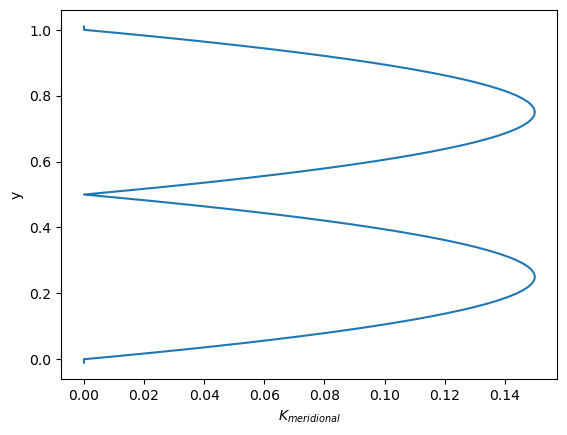

In [3]:
plt.plot(Kh_meridional, y)
plt.ylabel("y")
plt.xlabel(r"$K_{meridional}$")
plt.show()

In this profile, diffusivity drops to 0 at $y=0.5$ and at $y=0$ and $y=1$. In the absence of advection, particles starting out in one half of the domain should remain confined to that half as they are unable to cross the points where the diffusivity drops to 0. The line $y=0.5$ should therefore provide an impermeable barrier.

Now we can put this idealized profile into a flat fieldset:


In [8]:
from parcels._datasets.structured.generated import simple_UV_dataset

ds = simple_UV_dataset(dims=(1, 1, Ny, 1), mesh="flat").isel(time=0, depth=0)
ds["lat"][:] = np.linspace(-0.01, 1.01, Ny)
ds["lon"][:] = np.ones(len(ds.XG))
# dx, dy = 1.0 / len(ds.XG), 1.0 / len(ds.YG)
ds["Kh_zonal"] = ds["U"] + K_bar * np.ones((Ny,1))
ds["Kh_meridional"] = ds["U"] + Kh_meridional[:,None]
ds

<xarray.Dataset> Size: 6kB
Dimensions:        (YG: 103, XG: 1, YC: 103, XC: 1)
Coordinates:
    time           datetime64[ns] 8B 2000-01-01
    depth          float64 8B 0.0
  * YC             (YC) float64 824B 0.5 1.5 2.5 3.5 ... 99.5 100.5 101.5 102.5
  * YG             (YG) int64 824B 0 1 2 3 4 5 6 7 ... 96 97 98 99 100 101 102
  * XC             (XC) float64 8B 0.5
  * XG             (XG) int64 8B 0
    lat            (YG) float64 824B -0.01 0.0 0.01 0.02 ... 0.98 0.99 1.0 1.01
    lon            (XG) float64 8B 1.0
Data variables:
    U              (YG, XG) float64 824B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    V              (YG, XG) float64 824B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Kh_zonal       (YG, XG) float64 824B 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    Kh_meridional  (YG, XG) float64 824B 0.0 0.0 0.01176 ... 0.01176 0.0 0.0

In [11]:
grid = parcels.XGrid.from_dataset(ds, mesh="flat")
U = parcels.Field("U", ds["U"], grid, interp_method=parcels.interpolators.XLinear)
V = parcels.Field("V", ds["V"], grid, interp_method=parcels.interpolators.XLinear)
UV = parcels.VectorField("UV", U, V)
Kh_zonal_field = parcels.Field("Kh_zonal", ds["Kh_zonal"], grid, interp_method=parcels.interpolators.XLinear)
Kh_meridional_field = parcels.Field("Kh_meridional", ds["Kh_meridional"], grid, interp_method=parcels.interpolators.XLinear)
fieldset = parcels.FieldSet([U, V, UV, Kh_zonal_field, Kh_meridional_field])

fieldset.add_constant("dres", 0.00005)

We release 100 particles at ($x=0$, $y=0.75$).


In [17]:
def get_test_particles():
    return parcels.ParticleSet(
        fieldset,
        pclass=parcels.Particle,
        lon=np.zeros(100),
        lat=np.ones(100) * 0.75,
        time=np.repeat(np.timedelta64(0,'s'),100),
        # lonlatdepth_dtype=np.float64,
    )

Now we will simulate the advection and diffusion of the particles using the `AdvectionDiffusionM1` kernel. We run the simulation for 0.3 seconds, with a numerical timestep $\Delta t = 0.001$s. We also write away particle locations at each timestep for plotting. Note that this will hinder a runtime comparison between kernels, since it will cause most time to be spent on I/O.


In [ ]:
testParticles = get_test_particles()
testParticles.update_dt_dtype("timedelta64[ms]")
output_file = parcels.ParticleFile(
    store="M1_out.zarr", chunks=(len(testParticles), 50), outputdt=np.timedelta64(1,'ms')
)

testParticles.execute(
    parcels.kernels.AdvectionDiffusionM1,
    runtime=np.timedelta64(300,'ms'),
    dt=np.timedelta64(1,'ms'),
    output_file=output_file,
)

INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples_v3/M1_out.zarr
Integration time: 299000000 nanoseconds: 100%|██████████| 0.3000000000000002/0.3 [00:03<00:00, 10.83s/it] 


/Users/Gebruiker/Documents/UU/parcels/Parcels/.pixi/envs/test-notebooks/lib/python3.11/site-packages/tqdm/std.py:516: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(


In [24]:
M1_out = xr.open_zarr("M1_out.zarr")

We can plot the individual coordinates of the particle trajectories against time ($x$ against $t$ and $y$ against $t$) to investigate how diffusion works along each axis.


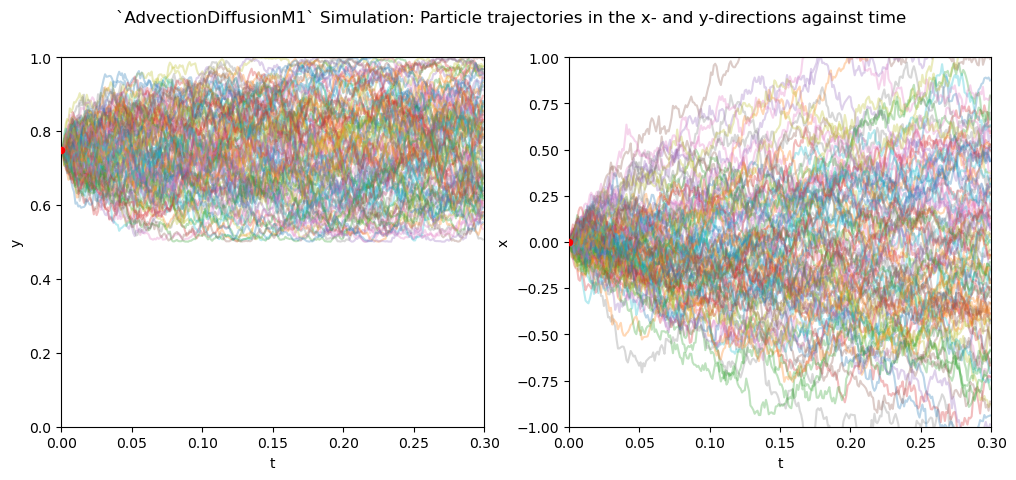

In [25]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

x = np.arange(0, 0.3, 0.001)
for data, ai, dim, ystart, ylim in zip(
    [M1_out.lat, M1_out.lon], ax, ("y", "x"), (0.75, 0), [(0, 1), (-1, 1)]
):
    ai.plot(x, data.T[: len(x), :], alpha=0.3)
    ai.scatter(0, ystart, s=20, c="r", zorder=3)
    ai.set_xlabel("t")
    ai.set_ylabel(dim)
    ai.set_xlim(0, 0.3)
    ai.set_ylim(ylim)

fig.suptitle(
    "`AdvectionDiffusionM1` Simulation: "
    f"Particle trajectories in the x- and y-directions against time"
)
plt.show()

We see that the along the meridional direction, particles remain confined to the ‘upper’ part of the domain, not crossing the impermeable barrier where the diffusivity drops to zero. In the zonal direction, particles follow random walks, since all terms involving gradients of the diffusivity are zero.

Now let's execute the simulation with the `AdvectionDiffusionEM` kernel instead.


In [33]:
testParticles = get_test_particles()
testParticles.update_dt_dtype("timedelta64[ms]")
output_file = parcels.ParticleFile(
    store="EM_out.zarr", chunks=(len(testParticles), 50), outputdt=np.timedelta64(1,'ms')
)
random.seed(1636)  # Random seed for reproducibility
testParticles.execute(
    parcels.kernels.AdvectionDiffusionEM,
    runtime=np.timedelta64(300,'ms'),
    dt=np.timedelta64(1,'ms'),
    output_file=output_file,
)

INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples_v3/EM_out.zarr
Integration time: 299000000 nanoseconds: 100%|██████████| 0.3000000000000002/0.3 [00:03<00:00, 10.62s/it] 


/Users/Gebruiker/Documents/UU/parcels/Parcels/.pixi/envs/test-notebooks/lib/python3.11/site-packages/tqdm/std.py:516: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(


In [34]:
EM_out = xr.open_zarr("EM_out.zarr")

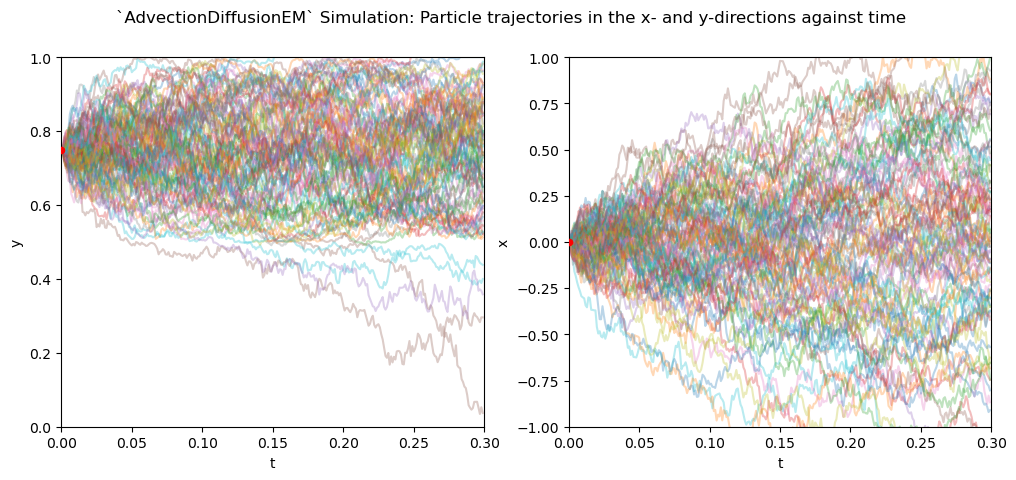

In [35]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

x = np.arange(0, 0.3, 0.001)
for data, ai, dim, ystart, ylim in zip(
    [EM_out.lat, EM_out.lon], ax, ("y", "x"), (0.75, 0), [(0, 1), (-1, 1)]
):
    ai.plot(x, data.T[: len(x), :], alpha=0.3)
    ai.scatter(0, ystart, s=20, c="r", zorder=3)
    ai.set_xlabel("t")
    ai.set_ylabel(dim)
    ai.set_xlim(0, 0.3)
    ai.set_ylim(ylim)

fig.suptitle(
    "`AdvectionDiffusionEM` Simulation: "
    f"Particle trajectories in the x- and y-directions against time"
)
plt.show()

The Wiener increments for both simulations are equal, as they are fixed through a random seed. As we can see, the Euler-Maruyama scheme performs worse than the Milstein scheme, letting particles cross the impermeable barrier at $y=0.5$. In contrast, along the zonal direction, particles follow the same random walk as in the Milstein scheme, which is expected since the extra terms in the Milstein scheme are zero in this case.


## Example: Using horizontal diffusion calculated from velocity fields

In the case when velocity fields are available, there is the possibility to calculate coefficients of diffusion based on closure parameterizations. The Smagorinsky method ([Smagorinsky, 1963](<https://doi.org/10.1175/1520-0493(1963)091%3C0099:GCEWTP%3E2.3.CO;2>)), which was originally proposed as a parameterization for horizontal eddy viscosity, is often used to parameterize horizontal eddy diffusivity as well. It computes the eddy diffusivity as

$$
K = C_s \Delta x \Delta y \sqrt{\left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial v}{\partial y}\right)^2 + \frac{1}{2}\left(\frac{\partial u}{\partial y} +\frac{\partial v}{\partial x}\right)^2},
$$

where $C_s$, the Smagorinsky constant, is a dimensionless tuning parameter. It uses the grid area $\Delta x \Delta y$ as its spatial scale, and the norm of the strain rate tensor as its time scale, given as the square-rooted term.

Let’s see the example of implementation of the Smagorinsky method to the GlobalCurrents files of the region around South Africa. For simplicity, we are not taking gradients in the Smagorinsky-computed diffusivity field into account here.

First, create a new kernel for Smagorinsky diffusion method:


In [ ]:
def smagdiff(particles, fieldset):
    dt = particles.dt / np.timedelta64(1, "s")
    dx = 0.01
    # gradients are computed by using a local central difference.
    updx, vpdx = fieldset.UV[particles.time, particles.depth, particles.lat, particles.lon + dx, particles]
    umdx, vmdx = fieldset.UV[particles.time, particles.depth, particles.lat, particles.lon - dx, particles]
    updy, vpdy = fieldset.UV[particles.time, particles.depth, particles.lat + dx, particles.lon, particles]
    umdy, vmdy = fieldset.UV[particles.time, particles.depth, particles.lat - dx, particles.lon, particles]

    dudx = (updx - umdx) / (2 * dx)
    dudy = (updy - umdy) / (2 * dx)

    dvdx = (vpdx - vmdx) / (2 * dx)
    dvdy = (vpdy - vmdy) / (2 * dx)

    A = fieldset.cell_areas[particles.time, 0, particles.lat, particles.lon]
    sq_deg_to_sq_m = (1852 * 60) ** 2 * math.cos(particles.lat * math.pi / 180)
    A = A / sq_deg_to_sq_m
    Kh = fieldset.Cs * A * math.sqrt(dudx**2 + 0.5 * (dudy + dvdx) ** 2 + dvdy**2)

    dlat = random.normalvariate(0.0, 1.0) * math.sqrt(2 * math.fabs(dt) * Kh)
    dlon = random.normalvariate(0.0, 1.0) * math.sqrt(2 * math.fabs(dt) * Kh)

    particle_dlat += dlat
    particle_dlon += dlon

Reading velocity fields from netcdf files


In [ ]:
example_dataset_folder = parcels.download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}

fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)

Adding parameters (`cell_areas` – areas of computational cells, and `Cs` – Smagorinsky constant) to `fieldset` that are needed for the `smagdiff` kernel


In [ ]:
x = fieldset.U.grid.lon
y = fieldset.U.grid.lat


def calc_cell_edge_sizes(grid):
    """Calculate cell sizes based on numpy.gradient method.

    Currently only works for Rectilinear Grids. Operates in place adding a `cell_edge_sizes`
    attribute to the grid.
    """
    assert grid._gtype in (GridType.RectilinearZGrid, GridType.RectilinearSGrid), (
        f"_cell_edge_sizes() not implemented for {grid._gtype} grids. "
        "You can provide cell_edge_sizes yourself by in, e.g., "
        "NEMO using the e1u fields etc from the mesh_mask.nc file."
    )

    cell_edge_sizes_x = np.zeros((grid.ydim, grid.xdim), dtype=np.float32)
    cell_edge_sizes_y = np.zeros((grid.ydim, grid.xdim), dtype=np.float32)

    x_conv = GeographicPolar() if grid.mesh == "spherical" else UnitConverter()
    y_conv = Geographic() if grid.mesh == "spherical" else UnitConverter()
    for y, (lat, dy) in enumerate(zip(grid.lat, np.gradient(grid.lat), strict=False)):
        for x, (lon, dx) in enumerate(
            zip(grid.lon, np.gradient(grid.lon), strict=False)
        ):
            cell_edge_sizes_x[y, x] = x_conv.to_source(dx, grid.depth[0], lat, lon)
            cell_edge_sizes_y[y, x] = y_conv.to_source(dy, grid.depth[0], lat, lon)
    return cell_edge_sizes_x, cell_edge_sizes_y


def calc_cell_areas(grid):
    cell_edge_sizes_x, cell_edge_sizes_y = calc_cell_edge_sizes(grid)
    return cell_edge_sizes_x * cell_edge_sizes_y


cell_areas = parcels.Field(
    name="cell_areas", data=calc_cell_areas(fieldset.U.grid), lon=x, lat=y
)
fieldset.add_field(cell_areas)

fieldset.add_constant("Cs", 0.1)

In the example, particles are released at one location periodically (every hour) for 12 hours


In [ ]:
time = np.arange(0, 43200, 3600)
lon = [29] * len(time)
lat = [-33] * len(time)
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=parcels.Particle, lon=lon, lat=lat, time=time
)

Simulating the particles moving during 7 days using advection (`AdvectionRK4`) and diffusion (`smagdiff`) kernels.


In [ ]:
def DeleteParticle(particle, fieldset, time):
    if particle.state == parcels.StatusCode.ErrorOutOfBounds:
        particle.delete()


output_file = pset.ParticleFile(
    name="Global_smagdiff.zarr", outputdt=timedelta(hours=3), chunks=(1, 57)
)

random.seed(1636)  # Random seed for reproducibility

pset.execute(
    [parcels.kernels.AdvectionRK4, smagdiff, DeleteParticle],
    runtime=timedelta(days=7),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

Visualize the trajectories using the trajan package


In [ ]:
ds = xr.open_zarr("Global_smagdiff.zarr")

ds.traj.plot()
plt.show()

## References

Gräwe, U. (2011). “Implementation of high-order particle-tracking schemes in a water column model.” _Ocean Modelling_, 36(1), 80–89. https://doi.org/10.1016/j.ocemod.2010.10.002

Gräwe, Deleersnijder, Shah & Heemink (2012). “Why the Euler scheme in particle tracking is not enough: The shallow-sea pycnocline test case.” _Ocean Dynamics_, 62(4), 501–514. https://doi.org/10.1007/s10236-012-0523-y

Maruyama, G. (1955). “Continuous Markov processes and stochastic equations.” _Rendiconti del Circolo Matematico di Palermo_, 4(1), 48.

van Sebille et al. (2018). “Lagrangian ocean analysis: Fundamentals and practices.” _Ocean Modelling_, 121, 49–75. https://doi.org/10.1016/j.ocemod.2017.11.008

Shah, S. H. A. M., Heemink, A. W., & Deleersnijder, E. (2011). “Assessing Lagrangian schemes for simulating diffusion on non-flat isopycnal surfaces.” _Ocean Modelling_, 39(3–4), 351–361. https://doi.org/10.1016/j.ocemod.2011.05.008
https://doi.org/10.1016/j.ocemod.2011.05.008

Shah, Primeau, Deleersnijder & Heemink (2017). “Tracing the Ventilation Pathways of the Deep North Pacific Ocean Using Lagrangian Particles and Eulerian Tracers.” _Journal of Physical Oceanography_, 47(6), 1261–1280. https://doi.org/10.1175/JPO-D-16-0098.1

Smagorinsky, J. (1963). “General circulation experiments with primitive equations. 1. The basic experiment.” _Monthly Weather Review_, 91, 99–164. https://doi.org/10.1175/1520-0493(1963)091%3C0099:GCEWTP%3E2.3.CO;2
